In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [2]:
from socialbehavior.models.hmm import HMM
from socialbehavior.observations.ar_sigmoid_normal_observation import ARSigmoidNormalObservation
from socialbehavior.distributions.sigmoidnormal import SigmoidNormal
from socialbehavior.transformations.linear import LinearTransformation
from socialbehavior.utils import find_permutation, random_rotation, k_step_prediction

import torch
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

from hips.plotting.colormaps import gradient_cmap, white_to_color_cmap
color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

from tqdm import tqdm_notebook as tqdm
import sys
import time

In [3]:
import joblib

datasets_processed = joblib.load('/Users/leah/Columbia/courses/19summer/SocialBehavior/tracedata/all_data_3_1')  # a list of length 30, each is a social_dataset

rendered_data = []
for dataset in datasets_processed:
    session_data = dataset.render_trajectories([3,8])  # list of length 2, each item is an array (T, 2). T = 36000
    rendered_data.append(np.concatenate((session_data),axis = 1)) # each item is an array (T, 4)
trajectories = np.concatenate(rendered_data,axis = 0)  # (T*30, 4)

traj29 = rendered_data[29]

In [53]:
def plot_2_mice(data):
    plt.plot(data[:,0], data[:,1], label='virgin')
    plt.plot(data[:,2], data[:,3], label='mother')
    plt.legend();

In [54]:
def plot_4_traces(data):
    plt.plot(data[:, 0], label='x1')
    plt.plot(data[:, 1], label='y1')
    plt.plot(data[:, 2], label='x2')
    plt.plot(data[:, 3], label='y2')
    plt.legend();

In [4]:
arena_xmax = 320
arena_ymax = 370

In [5]:
K = 5
D = 4
T = 36000

bounds = np.array([[-10, arena_xmax + 10], [-10, arena_ymax + 10], [-10, arena_xmax + 10],
                   [-10, arena_ymax + 10]])

#bounds = np.array([[-300, 300], [-300, 300], [-300, 300], [-300, 300]])

In [6]:
tran = LinearTransformation(K=K, d_in=D, d_out=D)
observation = ARSigmoidNormalObservation(K=K, D=D, M=0, transformation=tran, bounds=bounds, alpha=0.5)

model = HMM(K=K, D=D, M=0, observation=observation)

data = torch.tensor(traj29, dtype=torch.float64)

In [7]:
model.log_likelihood(data)

tensor(-1.1873e+09, dtype=torch.float64, grad_fn=<HMMNormalizerCythonBackward>)

In [8]:
num_iters = 2000
pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer = torch.optim.Adam(model.params, lr=0.005)

losses = []
for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(data)
    loss.backward(retain_graph=True)
    optimizer.step()
    losses.append(loss.detach().numpy())
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)
        
pbar.close()

In [9]:
num_iters = 3000
pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer = torch.optim.Adam(model.params, lr=0.001)

for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(data)
    loss.backward(retain_graph=True)
    optimizer.step()
    losses.append(loss.detach().numpy())
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)
        
pbar.close()

In [52]:
num_iters = 1000
pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer = torch.optim.Adam(model.params, lr=0.0005)

for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(data)
    loss.backward(retain_graph=True)
    optimizer.step()
    losses.append(loss.detach().numpy())
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)
        
pbar.close()

In [58]:
for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(data)
    loss.backward(retain_graph=True)
    optimizer.step()
    losses.append(loss.detach().numpy())
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)
        
pbar.close()

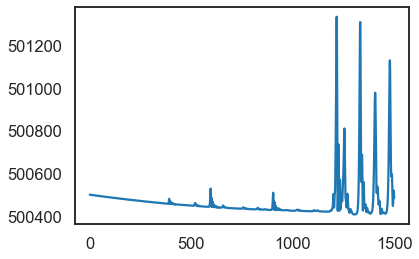

In [59]:
plt.plot(losses[5500:])

## check samples

In [370]:
sample_z, sample_x = model.sample(5000)

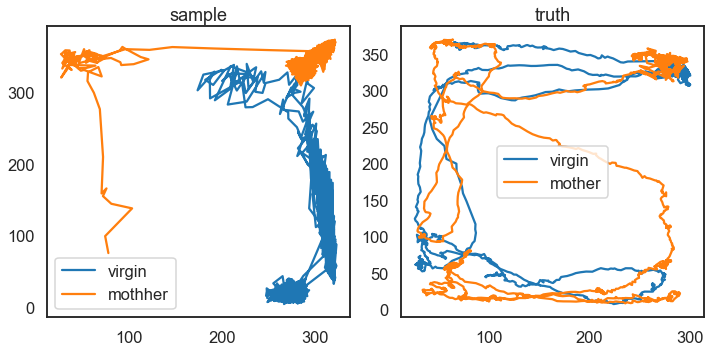

In [371]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(sample_x[:,0], sample_x[:,1], label='virgin')
axs[0].plot(sample_x[:,2], sample_x[:, 3], label='mothher')
axs[0].legend()
axs[0].set_title('sample')

axs[1].plot(traj29[:5000,0], traj29[:5000,1], label='virgin')
axs[1].plot(traj29[:5000,2], traj29[:5000,3], label='mother')
axs[1].legend()
axs[1].set_title('truth')

plt.tight_layout()

In [127]:
def plot_4_traces(data):
    plt.plot(data[:, 0], label='x1')
    plt.plot(data[:, 1], label='y1')
    plt.plot(data[:, 2], label='x2')
    plt.plot(data[:, 3], label='y2')
    plt.legend();

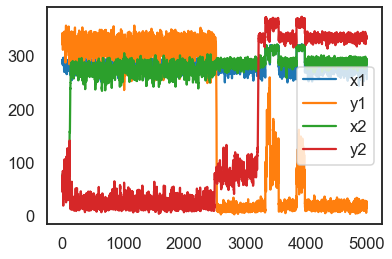

In [128]:
plot_4_traces(sample_x)

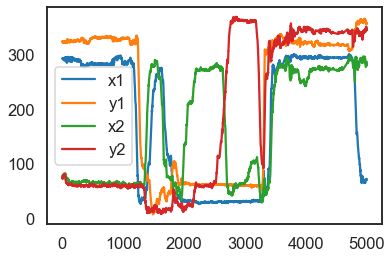

In [130]:
plot_4_traces(data[:5000].numpy())

## check prediction

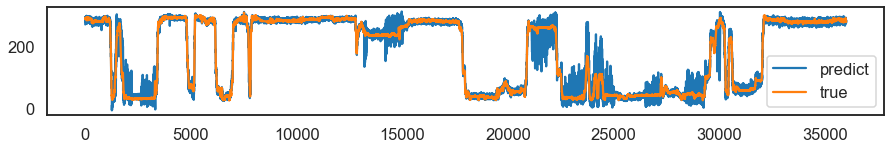

In [251]:
z = model.most_likely_states(data)
x_predict_arr = k_step_prediction(model, z, data)

plt.figure(figsize=(15,2))
plt.plot(x_predict_arr[:,0], label='predict')
plt.plot(data[:,0].numpy(), label='true')
plt.legend()
plt.show()

([], <a list of 0 Text yticklabel objects>)

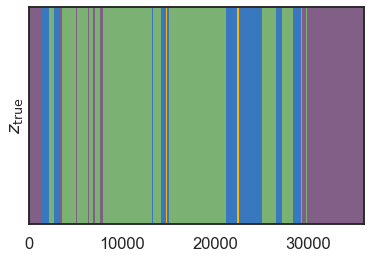

In [252]:
plt.imshow(z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

In [378]:
[sum(z==k) for k in range(K)]

[7952, 0, 200, 19289, 8559]

## quiver plots

In [134]:
bounds

array([[-10, 330],
       [-10, 380],
       [-10, 330],
       [-10, 380]])

In [255]:
XX, YY = np.meshgrid(np.linspace(0, 320, 10), 
                     np.linspace(0, 370, 10))
XY = np.column_stack((np.ravel(XX), np.ravel(YY))) # shape (100,2) grid values

In [256]:
XYs = np.tile(XY, (1, 2))

In [257]:
XYs_next = np.zeros_like(XYs)

In [258]:
mus = tran.transform(torch.tensor(XYs, dtype=torch.float64))

In [259]:
p = SigmoidNormal(mus=mus, log_sigmas=observation.log_sigmas, bounds=bounds, alpha=0.5)

In [260]:
samples = p.sample((10000,))

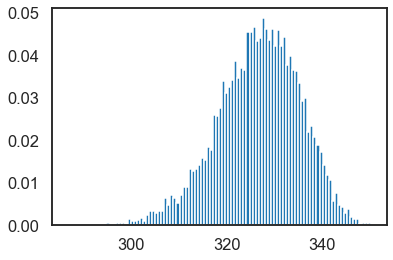

In [261]:
plt.hist(samples[:,30,3,1], bins=100, density=True);

In [262]:
mean = torch.mean(samples, dim=0)

In [263]:
std = torch.std(samples, dim=0)

In [264]:
dXYs = mean.numpy() - XYs[:, None]

### If the two mice are in same position

### dynamics for the virgin mouse

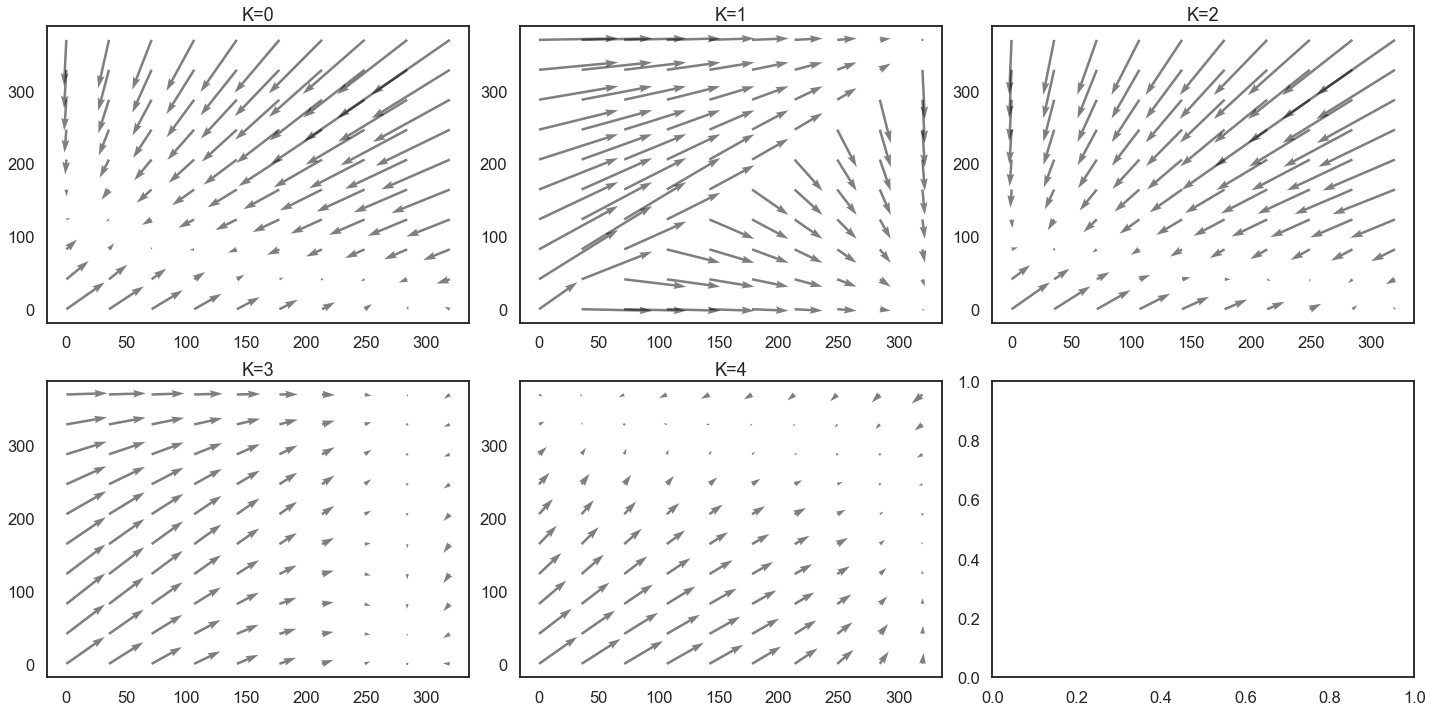

In [265]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

axs[0][0].quiver(XYs[:,0], XYs[:,1], dXYs[:, 0, 0], dXYs[:, 0, 1],
                       angles='xy', scale_units='xy', scale=5, alpha=0.5)
axs[0][0].set_title('K=0')

axs[0][1].quiver(XYs[:,0], XYs[:,1], dXYs[:, 1, 0], dXYs[:, 1, 1],
                       angles='xy', scale_units='xy', scale=5, alpha=0.5)
axs[0][1].set_title('K=1')

axs[0][2].quiver(XYs[:,0], XYs[:,1], dXYs[:, 2, 0], dXYs[:, 2, 1],
                       angles='xy', scale_units='xy', scale=5, alpha=0.5)
axs[0][2].set_title('K=2')

axs[1][0].quiver(XYs[:,0], XYs[:,1], dXYs[:, 3, 0], dXYs[:, 3, 1],
                       angles='xy', scale_units='xy', scale=5, alpha=0.5)
axs[1][0].set_title('K=3')

axs[1][1].quiver(XYs[:,0], XYs[:,1], dXYs[:, 4, 0], dXYs[:, 4, 1],
                       angles='xy', scale_units='xy', scale=5, alpha=0.5)
axs[1][1].set_title('K=4')


plt.tight_layout()

### dynamics for thhe mother mouse

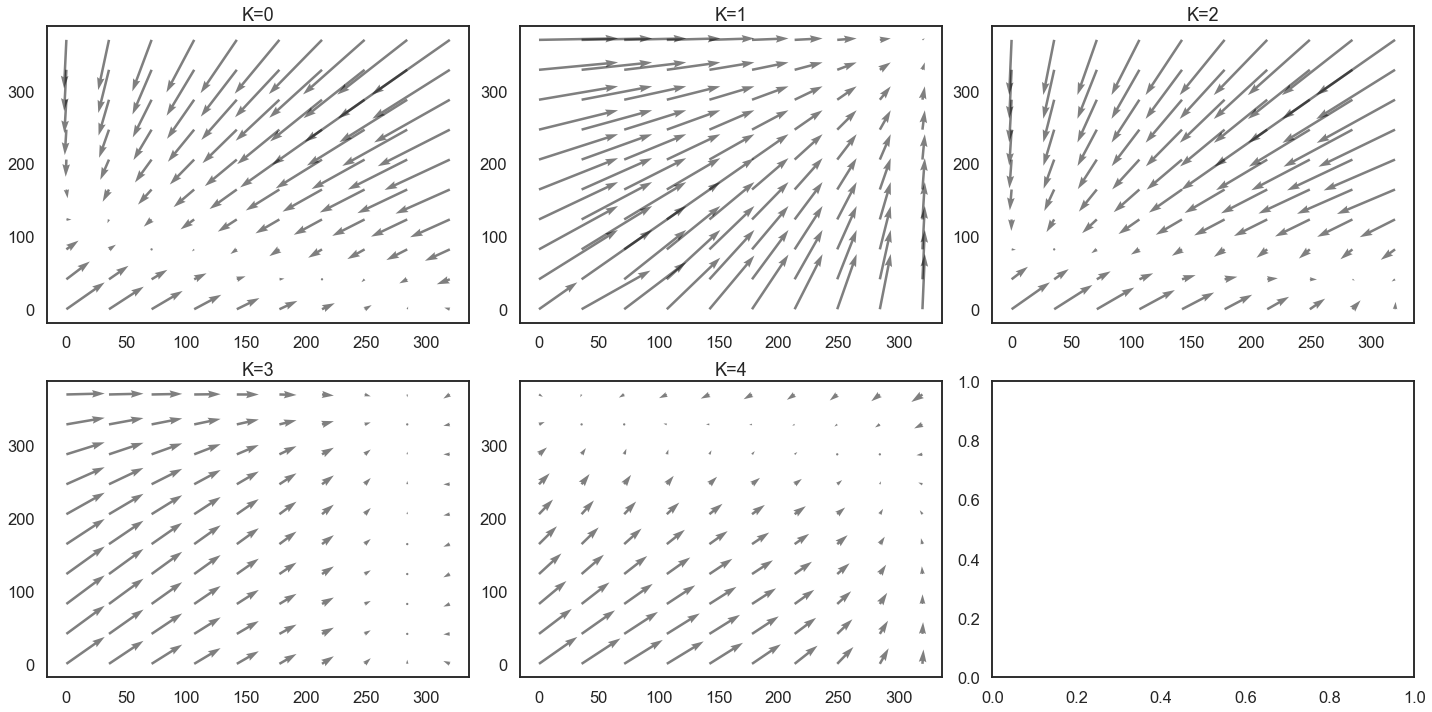

In [266]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

axs[0][0].quiver(XYs[:,0], XYs[:,1], dXYs[:, 0, 2], dXYs[:, 0, 3],
                       angles='xy', scale_units='xy', scale=5, alpha=0.5)
axs[0][0].set_title('K=0')

axs[0][1].quiver(XYs[:,0], XYs[:,1], dXYs[:, 1, 2], dXYs[:, 1, 3],
                       angles='xy', scale_units='xy', scale=5, alpha=0.5)
axs[0][1].set_title('K=1')

axs[0][2].quiver(XYs[:,0], XYs[:,1], dXYs[:, 2, 2], dXYs[:, 2, 3],
                       angles='xy', scale_units='xy', scale=5, alpha=0.5)
axs[0][2].set_title('K=2')

axs[1][0].quiver(XYs[:,0], XYs[:,1], dXYs[:, 3, 2], dXYs[:, 3, 3],
                       angles='xy', scale_units='xy', scale=5, alpha=0.5)
axs[1][0].set_title('K=3')

axs[1][1].quiver(XYs[:,0], XYs[:,1], dXYs[:, 4, 2], dXYs[:, 4, 3],
                       angles='xy', scale_units='xy', scale=5, alpha=0.5)
axs[1][1].set_title('K=4')


plt.tight_layout()

### fix the other mouse's position

#### center

In [267]:
XX, YY = np.meshgrid(np.linspace(0, 320, 10), 
                     np.linspace(0, 370, 10))
XY = np.column_stack((np.ravel(XX), np.ravel(YY))) # shape (100,2) grid values

In [268]:
XY_other = np.array([320/2, 370/2])

In [269]:
XY_other = np.tile(XY_other[None,], (100,1))

In [270]:
XY_virgin = np.concatenate((XY, XY_other), axis=1)
XY_mother = np.concatenate((XY_other, XY), axis=1)

In [271]:
mus_virgin = tran.transform(torch.tensor(XY_virgin, dtype=torch.float64))
p_virgin = SigmoidNormal(mus=mus_virgin, log_sigmas=observation.log_sigmas, bounds=bounds, alpha=0.5)

mus_mother = tran.transform(torch.tensor(XY_mother, dtype=torch.float64))
p_mother = SigmoidNormal(mus=mus_mother, log_sigmas=observation.log_sigmas, bounds=bounds, alpha=0.5)

In [272]:
samples_virgin = p_virgin.sample((10000,))
samples_mother = p_mother.sample((10000,))

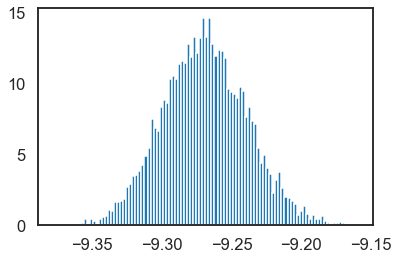

In [273]:
plt.hist(samples_virgin[:,0,2,1], bins=100, density=True);

In [274]:
dXY_virgin = torch.mean(samples_virgin, dim=0).numpy() - XY_virgin[:, None]
dXY_mother = torch.mean(samples_mother, dim=0).numpy() - XY_mother[:, None]

In [362]:
def plot_quiver(XYs, dXYs, mouse, other_mouse_loc=None):
    if mouse == 'virgin':
        i = 0
        j = 1
    elif mouse == 'mother':
        i = 2
        j = 3
        
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))

    axs[0][0].quiver(XYs[:,i], XYs[:,j], dXYs[:, 0, i], dXYs[:, 0, j],
                           angles='xy', scale_units='xy', scale=5, alpha=0.5)
    axs[0][0].set_title('K=0')

    axs[0][1].quiver(XYs[:,i], XYs[:,j], dXYs[:, 1, i], dXYs[:, 1, j],
                           angles='xy', scale_units='xy', scale=5, alpha=0.5)
    axs[0][1].set_title('K=1')

    axs[0][2].quiver(XYs[:,i], XYs[:,j], dXYs[:, 2, i], dXYs[:, 2, j],
                           angles='xy', scale_units='xy', scale=5, alpha=0.5)
    axs[0][2].set_title('K=2')

    axs[1][0].quiver(XYs[:,i], XYs[:,j], dXYs[:, 3, i], dXYs[:, 3, j],
                           angles='xy', scale_units='xy', scale=5, alpha=0.5)
    axs[1][0].set_title('K=3')
    
    axs[1][1].quiver(XYs[:,i], XYs[:,j], dXYs[:, 4, i], dXYs[:, 4, j],
                           angles='xy', scale_units='xy', scale=5, alpha=0.5)
    axs[1][1].set_title('K=4')
    
    if other_mouse_loc is not None:
        axs[0][0].plot(*other_mouse_loc, 'ro')
        axs[0][1].plot(*other_mouse_loc, 'ro')
        axs[0][2].plot(*other_mouse_loc, 'ro')
        axs[1][0].plot(*other_mouse_loc, 'ro')
        axs[1][1].plot(*other_mouse_loc, 'ro')
    """
    for row_axs in axs:
        for ax in row_axs:
            ax.set_xlim([0, 330])
            ax.set_ylim([0, 380])
    """
    plt.tight_layout()

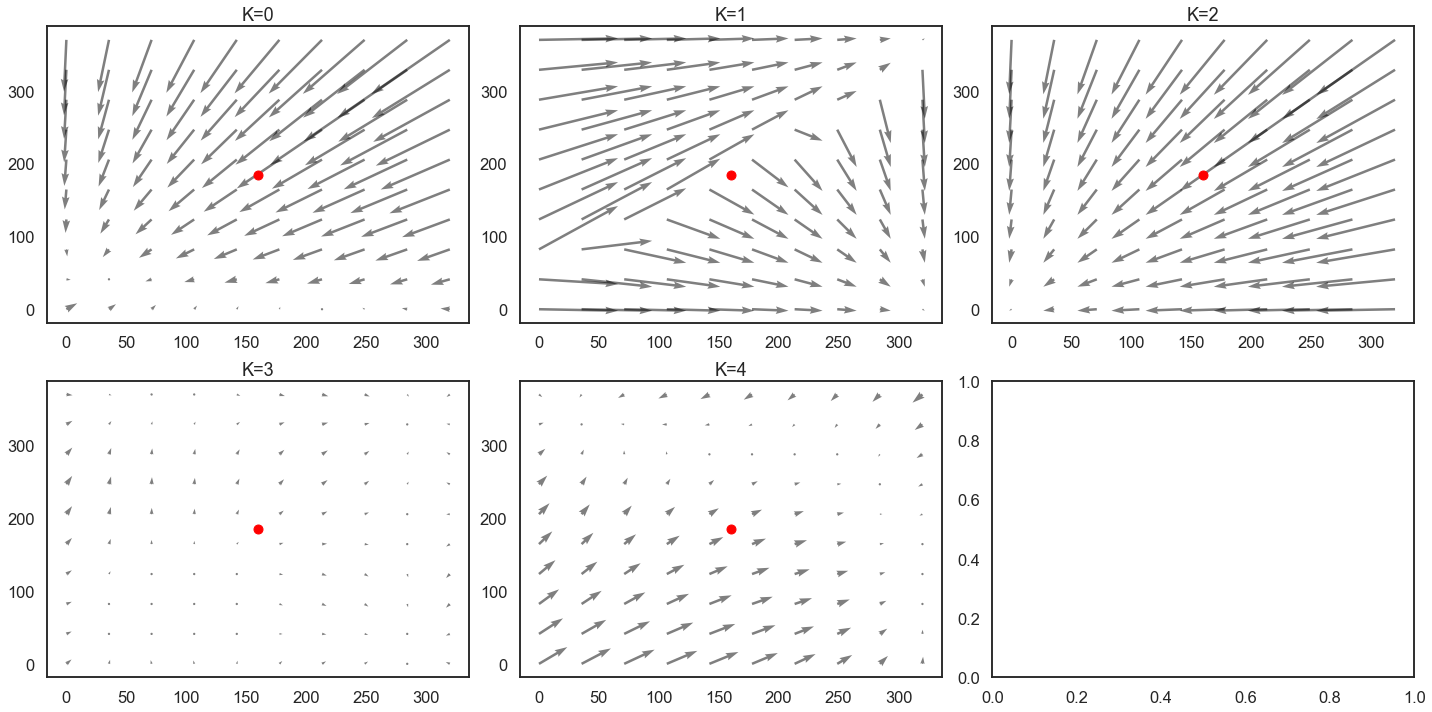

In [360]:
plot_quiver(XY_virgin, dXY_virgin, 'virgin', [320/2, 370/2])


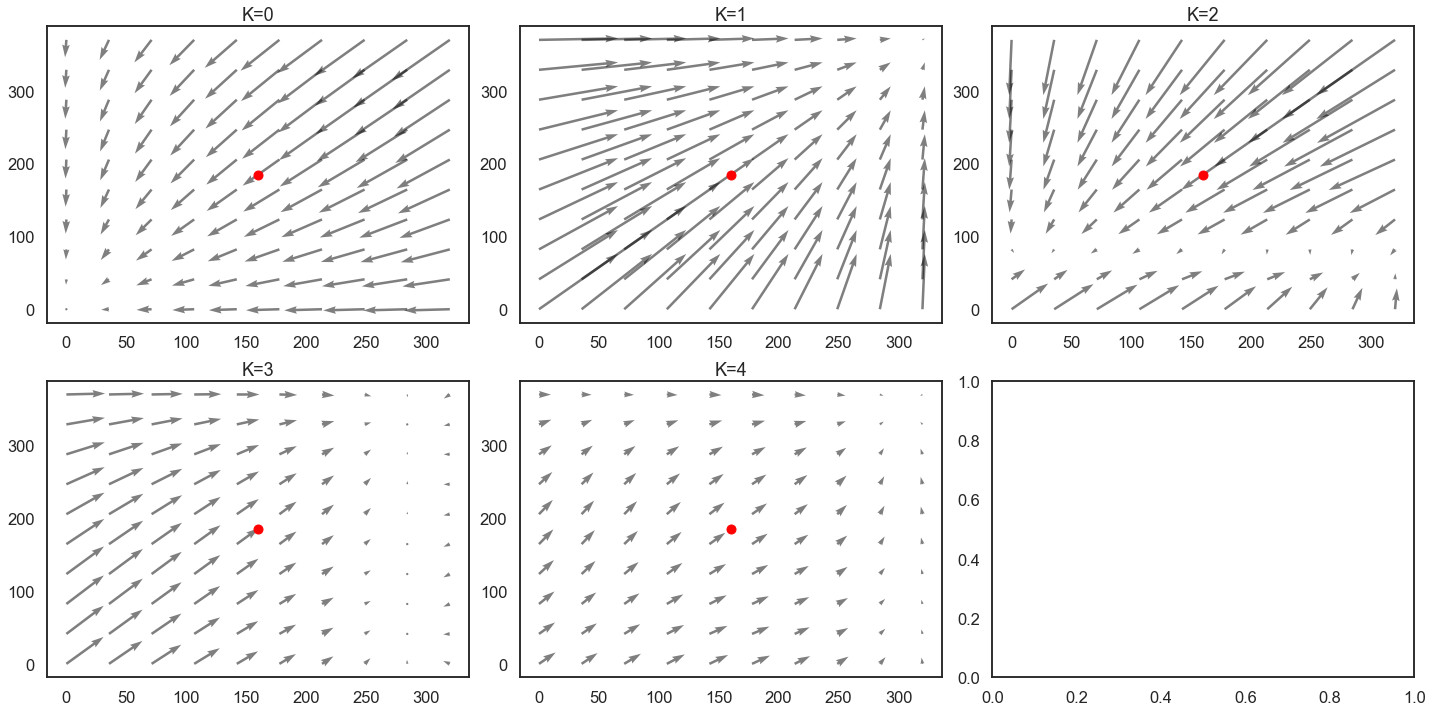

In [277]:
plot_quiver(XY_mother, dXY_mother, 'mother', [320/2, 370/2])


## corner

In [278]:
nest = np.array([270, 330])

In [279]:
XX, YY = np.meshgrid(np.linspace(0, 320, 10), 
                     np.linspace(0, 370, 10))
XY = np.column_stack((np.ravel(XX), np.ravel(YY))) # shape (100,2) grid values

XY_other = np.tile(nest[None,], (100,1))

XY_virgin = np.concatenate((XY, XY_other), axis=1)
XY_mother = np.concatenate((XY_other, XY), axis=1)

mus_virgin = tran.transform(torch.tensor(XY_virgin, dtype=torch.float64))
p_virgin = SigmoidNormal(mus=mus_virgin, log_sigmas=observation.log_sigmas, bounds=bounds, alpha=0.5)

mus_mother = tran.transform(torch.tensor(XY_mother, dtype=torch.float64))
p_mother = SigmoidNormal(mus=mus_mother, log_sigmas=observation.log_sigmas, bounds=bounds, alpha=0.5)

samples_virgin = p_virgin.sample((10000,))
samples_mother = p_mother.sample((10000,))

dXY_virgin = torch.mean(samples_virgin, dim=0).numpy() - XY_virgin[:, None]
dXY_mother = torch.mean(samples_mother, dim=0).numpy() - XY_mother[:, None]

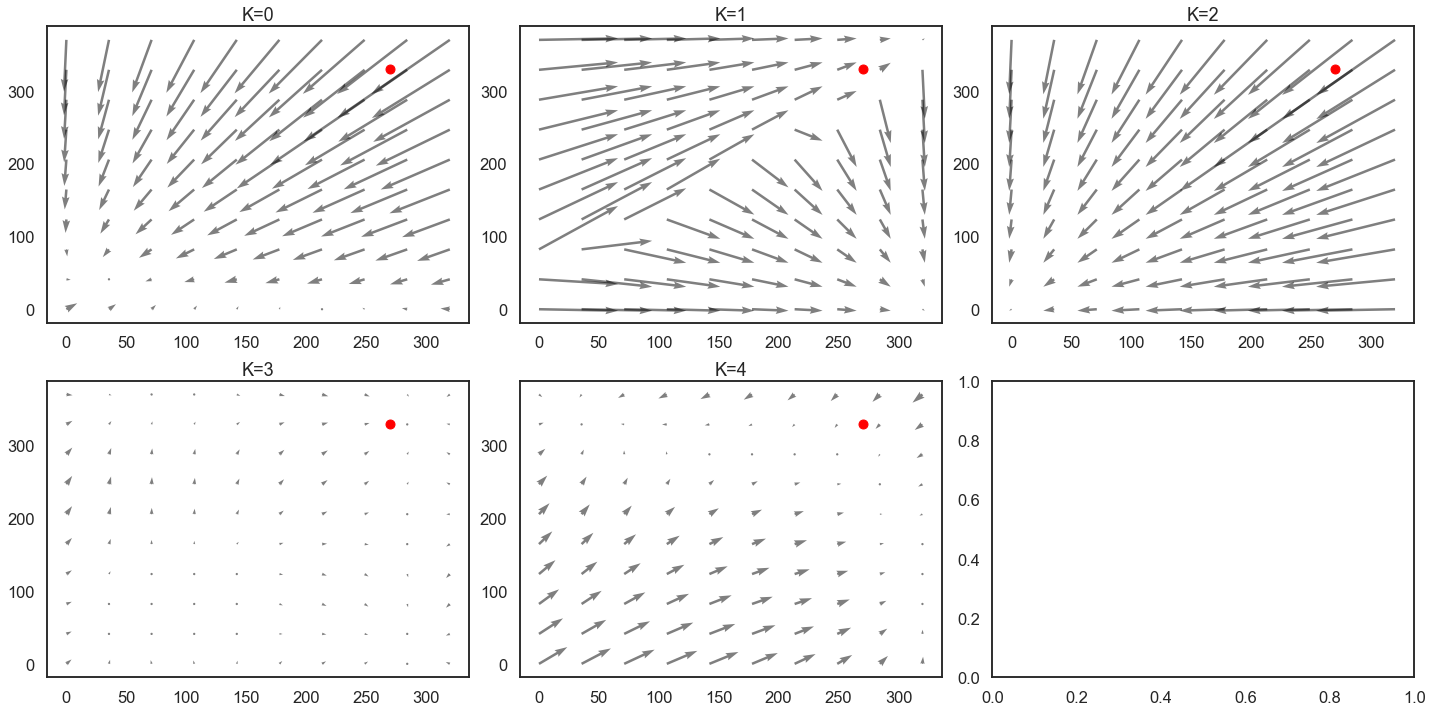

In [280]:
plot_quiver(XY_virgin, dXY_virgin, 'virgin', nest)

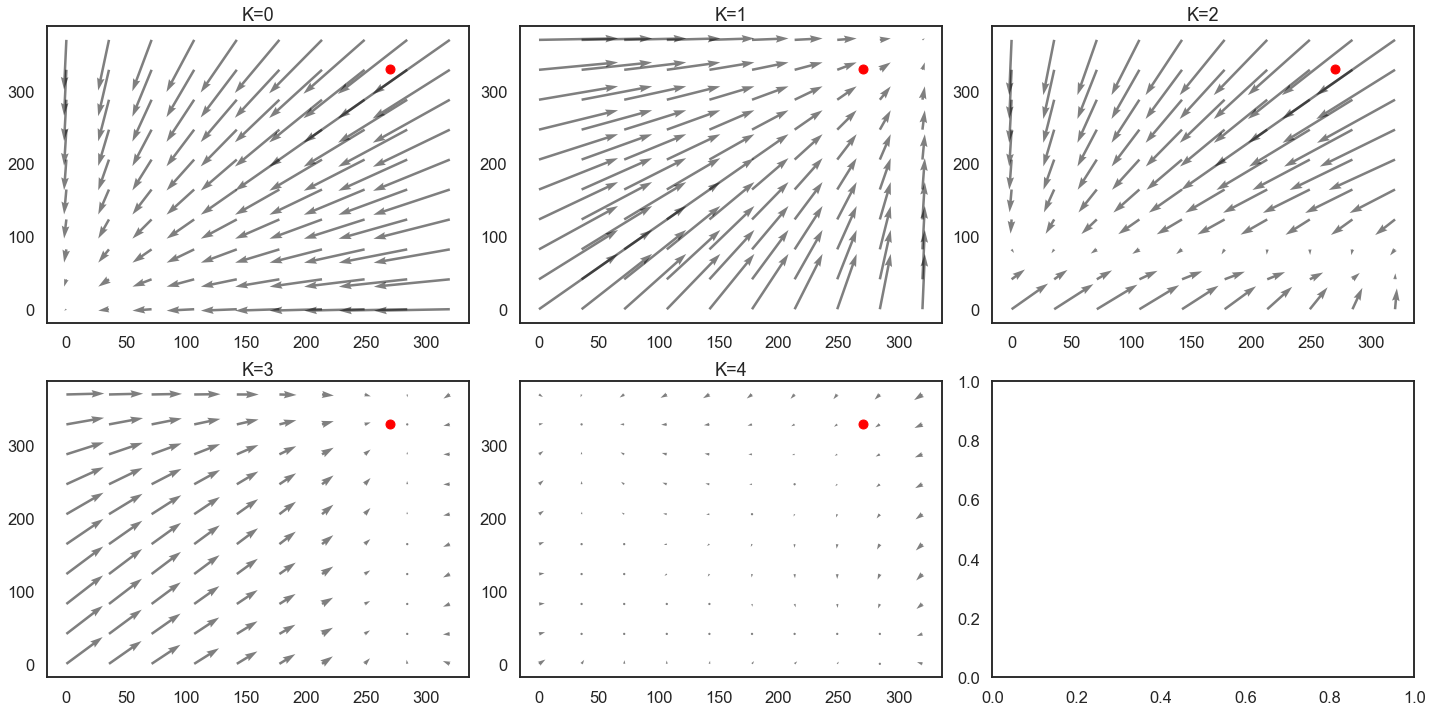

In [281]:
plot_quiver(XY_mother, dXY_mother, 'mother', nest)

### check the dynamic of the original data

In [303]:
data.shape

torch.Size([36000, 4])

In [304]:
mus = tran.transform(data)
p_data = SigmoidNormal(mus=mus, log_sigmas=observation.log_sigmas, bounds=bounds, alpha=0.5)

In [328]:
samples = p_data.sample((100,))

In [339]:
mean = torch.mean(samples, dim=0).numpy()
mean.shape

(36000, 5, 4)

In [307]:
d_data = torch.mean(samples, dim=0).numpy() - data.numpy()[:,None]

In [308]:
std = torch.std(samples, dim=0)
std.shape

torch.Size([36000, 5, 4])

In [325]:
std[1290][0][1]

tensor(40.6786, dtype=torch.float64)

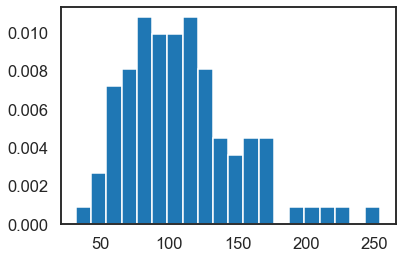

In [331]:
plt.hist(samples[:,1290, 0,1].numpy(), bins=20, density=True);

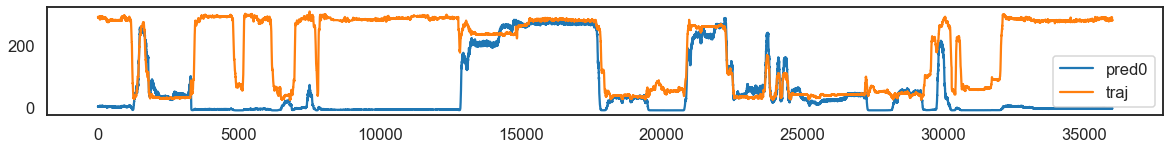

In [361]:
plt.figure(figsize=(20,2))
plt.plot(mean[:-1,0,0], label='pred0')
#plt.plot(mean[:-1,1,0], label='pred1')
#plt.plot(mean[:-1,2,0], label='pred2')
#plt.plot(mean[:-1,3,0], label='pred3')
#plt.plot(mean[:-1,4,0], label='pred4')
plt.plot(traj29[1:,0], label='traj')
plt.legend()

In [ ]:
plt.figure(figsize=(20,2))
plt.plot(std[:,0,0].numpy()*10, label='std')
plt.plot(traj29[:,0], label='traj')

In [300]:
std.shape

torch.Size([100, 5, 4])

In [185]:
torch.exp(observation.log_sigmas)

tensor([[8.0996e-01, 9.9426e-01, 7.2667e-01, 9.8541e-01],
        [4.3511e-03, 6.1382e-05, 5.5494e-05, 6.3818e-05],
        [5.9531e-02, 8.2605e-02, 7.3036e-02, 7.0018e-02],
        [1.8527e-01, 3.7683e-01, 2.6836e-01, 1.9724e-01],
        [2.6470e-01, 5.1286e-01, 2.5462e-01, 4.6448e-01]], dtype=torch.float64,
       grad_fn=<ExpBackward>)

In [190]:
np.ones((K, D)) * 0.005

array([[0.005, 0.005, 0.005, 0.005],
       [0.005, 0.005, 0.005, 0.005],
       [0.005, 0.005, 0.005, 0.005],
       [0.005, 0.005, 0.005, 0.005],
       [0.005, 0.005, 0.005, 0.005]])

std that are too large: 
(0,0), (3,0), (4,0),

(0,1), (3,1), (4,1),

(0,2), (3,2), (4,2), 

(0,3), (3,3), (4,3)

In [139]:
[sum(z==k) for k in range(K)]

[7952, 0, 200, 19289, 8559]

Text(0.5, 1, 'true trajectory clip')

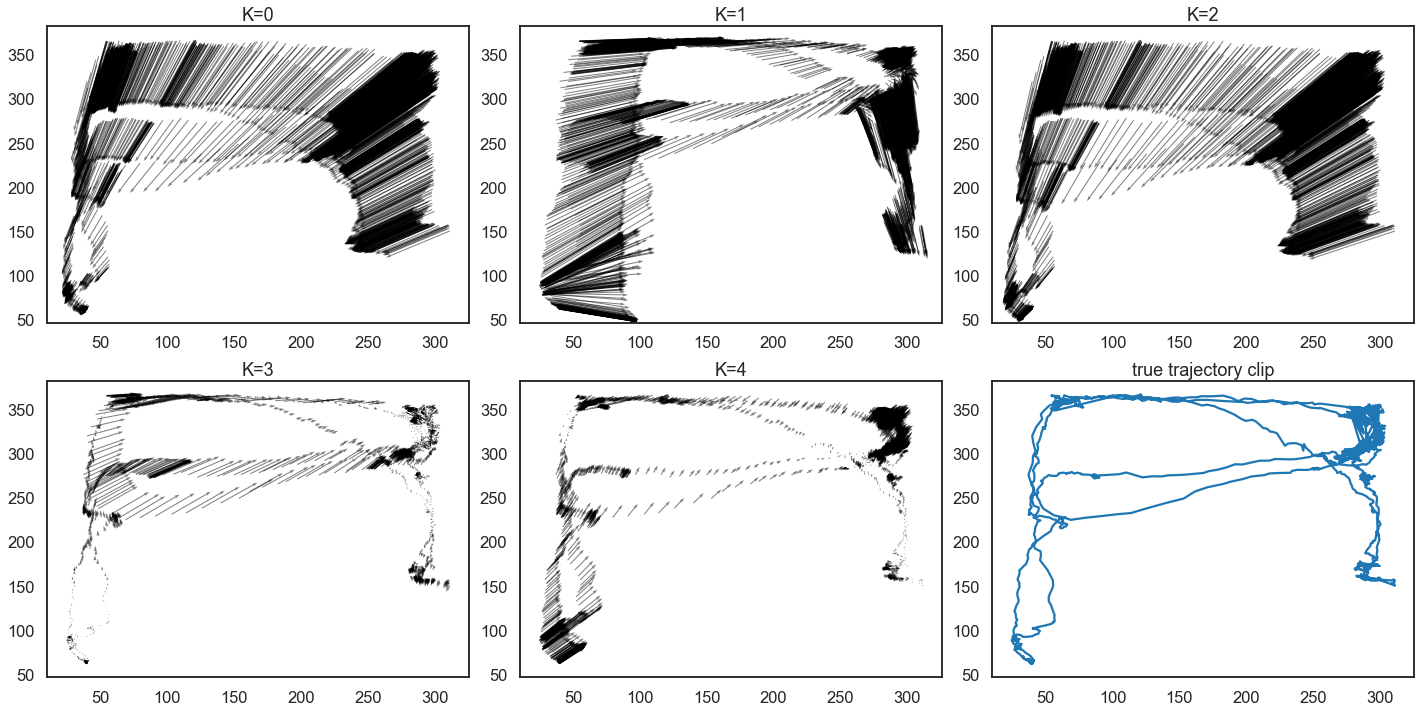

In [366]:
plot_quiver(data[5000:10000], d_data[5000:10000], 'virgin')
plt.plot(traj29[5000:10000,0], traj29[5000:10000,1])
plt.title('true trajectory clip')

Text(0.5, 1, 'true trajectory clip')

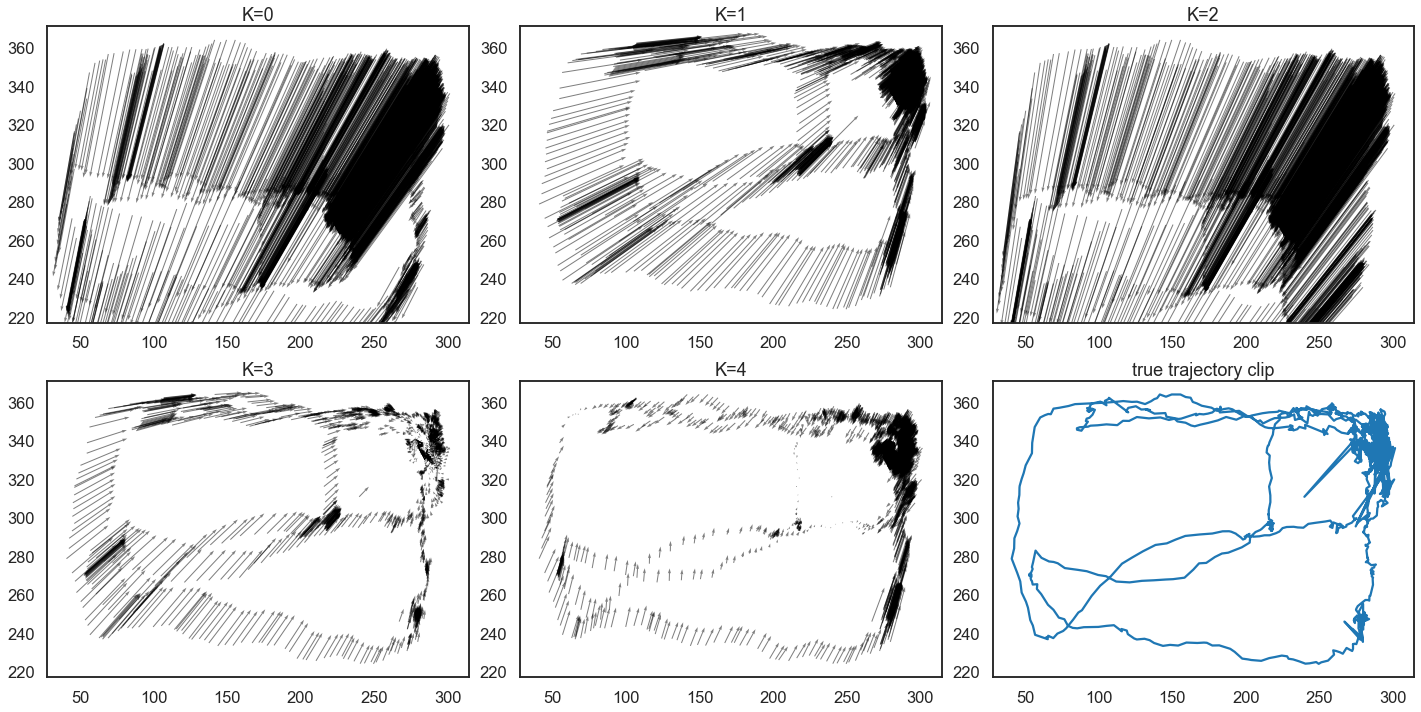

In [375]:
plot_quiver(data[5000:10000], d_data[5000:10000], 'mother')
plt.plot(traj29[5000:10000,2], traj29[5000:10000,3])
plt.title('true trajectory clip')

(0, 370)

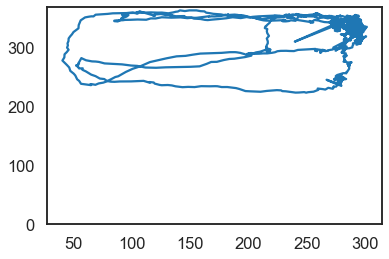

In [377]:
plt.plot(traj29[5000:10000,2], traj29[5000:10000,3])
plt.ylim([0,370])